### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
273,PSID89,0,16,9,0,0,0,1,2539.210,4579.6450,0.0000
508,PSID324,0,24,9,0,0,1,1,3438.513,0.0000,818.6605
260,PSID76,0,26,12,0,1,0,0,7968.338,5109.5810,4181.9660
328,PSID144,0,35,12,0,0,1,0,1469.450,2719.5000,0.0000
130,NSW131,1,17,9,1,0,0,1,1716.509,1253.4390,5445.2000
125,NSW126,1,27,9,1,0,1,1,0.000,934.4454,1773.4230
182,NSW183,1,35,9,1,0,1,1,13602.430,13830.6400,12803.9700
593,PSID409,0,17,10,0,0,0,1,0.000,0.0000,14942.7700
311,PSID127,0,18,11,0,0,0,1,0.000,3226.1610,15814.6300
434,PSID250,0,32,13,0,0,1,0,12553.020,524.5645,15353.5800


In [3]:
%config Completer.use_jedi = False

## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [4]:
df.groupby('treat').re78.describe().T

treat,0,1
count,429.000000,185.000000
mean,6984.169742,6349.143530
std,7294.161791,7867.402218
min,0.000000,0.000000
25%,220.181300,485.229800
50%,4975.505000,4232.309000
75%,11688.820000,9642.999000
max,25564.670000,60307.930000


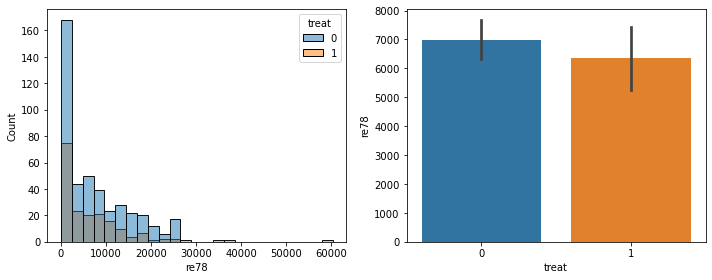

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(x='re78', hue='treat', data=df, ax=ax[0])
sns.barplot(x='treat', y='re78', data=df, ax=ax[1])
plt.tight_layout()

Looking only at the means may lead to think that the treatment decreases the revenue. A more cautious conclusion would be "we don't know", as the confidence intervals obtained by bootstrapping suggest that there is no difference between the two groups. A researcher would not draw any conclusion and perform more intensive analysis. 

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [6]:
cont = ['age', 'educ', 're74', 're75']
discrete = ['black', 'hispan', 'married', 'nodegree']

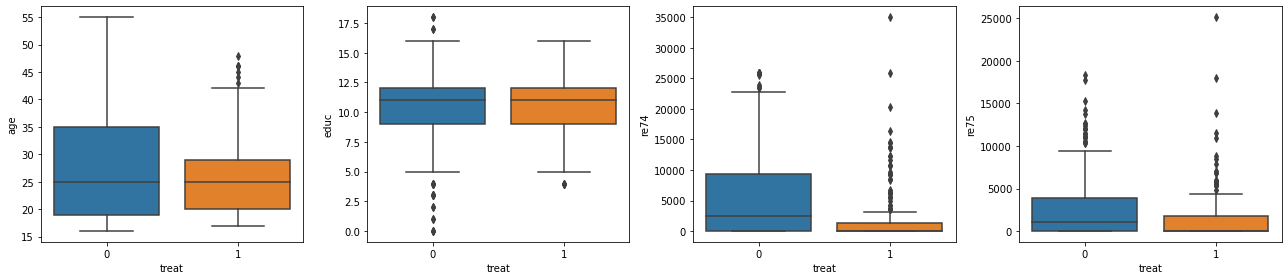

In [7]:
fig, ax = plt.subplots(1, len(cont), figsize=(18, 4))

for col, a in zip(cont, ax):
    sns.boxplot(y=col, data=df, ax=a, x='treat')
    
plt.tight_layout()

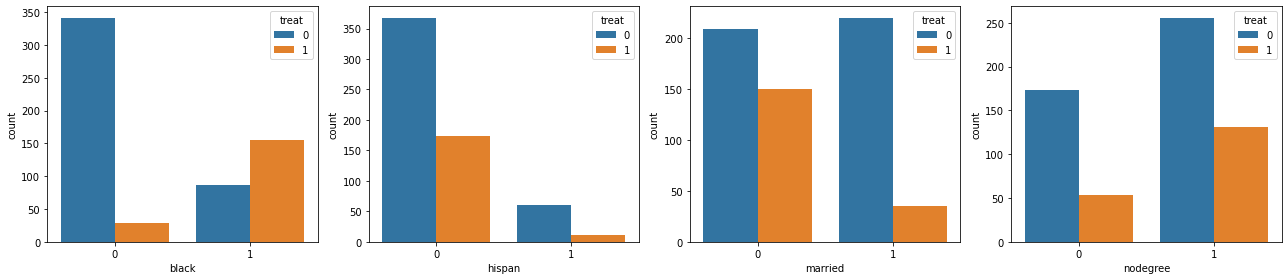

In [8]:
fig, ax = plt.subplots(1, len(cont), figsize=(18, 4))

for col, a in zip(discrete, ax):
    sns.countplot(x=col, data=df, ax=a, hue='treat')
    
plt.tight_layout()

The features are not evenly distributed among features. This makes the raw comparison between mean `re78` values of the two groups even less valid.

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [15]:
import statsmodels.formula.api as smf

In [27]:
features = df.columns.drop(['id', 're78', 'treat'])
formula = 'treat ~ ' + ' + '.join(features)
print(formula)
model = smf.logit(formula, data=df)
res = model.fit();

treat ~ age + educ + black + hispan + married + nodegree + re74 + re75
Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


In [29]:
df['prop'] = res.predict(df)
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.638770
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.224634
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.678244
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.776324
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.701639


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [30]:
import networkx as nx
from itertools import combinations

In [50]:
similarity = lambda x, y: 1 - abs(x - y)

In [54]:
G = nx.Graph()
ctrl = df[df.treat == 0]
treat = df[df.treat == 1]

for i in ctrl.index:
    for j in treat.index:
        G.add_weighted_edges_from([(i, j, similarity(ctrl.prop[i], treat.prop[j]))])

In [55]:
res = nx.max_weight_matching(G)

In [70]:
# Sanity check: group sizes
len(res), ctrl.shape, treat.shape

(185, (429, 12), (185, 12))

We have as many pairs as there are samples in the smallest group as expected.

In [58]:
# Sanity check: compare propensity scores for a few matched pairs
[
    (df.prop[i], df.prop[j])
    for i, j in list(res)[:5]
]

[(0.7073581280624237, 0.6428928863443855),
 (0.25032724580936844, 0.19513574630324348),
 (0.6923904188470772, 0.6957404748321194),
 (0.7186015041690507, 0.7093136434802998),
 (0.7763240815473471, 0.6196130966921487)]

The scores are pretty close, the method is likely to have worked well. 

We can now keep only matched samples:

In [59]:
# Keep a copy of data in case we need it later
raw = df.copy()

In [74]:
# "Linearize" the set of tuples of indices to a list of indices
matched_samples = np.ravel(list(res))
matched_samples.shape

df = df.loc[matched_samples]

We now visualize again the distribution of features among the control and treatment groups:

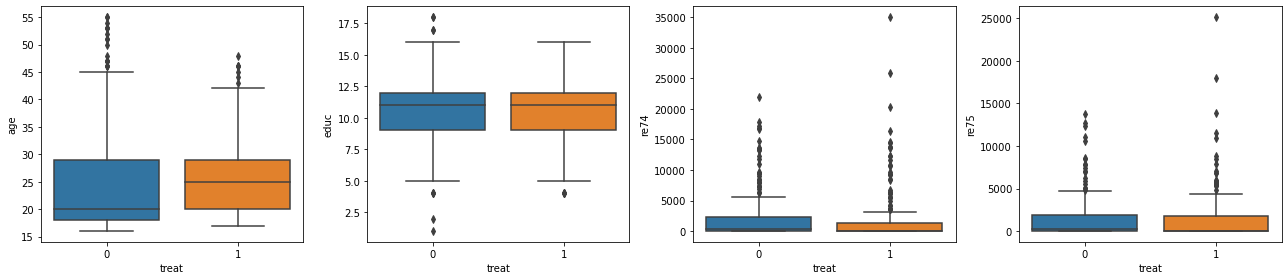

In [76]:
fig, ax = plt.subplots(1, len(cont), figsize=(18, 4))

for col, a in zip(cont, ax):
    sns.boxplot(y=col, data=df, ax=a, x='treat')
    
plt.tight_layout()

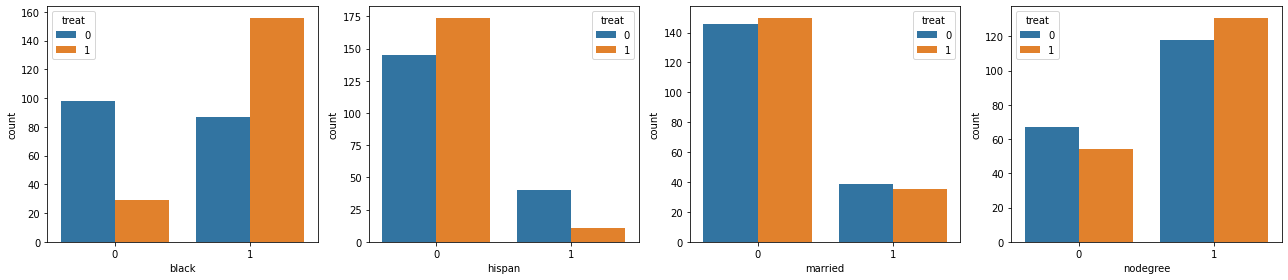

In [77]:
fig, ax = plt.subplots(1, len(cont), figsize=(18, 4))

for col, a in zip(discrete, ax):
    sns.countplot(x=col, data=df, ax=a, hue='treat')
    
plt.tight_layout()

The groups are now much more balanced, except for `black` and `hispan`. Comparing the distribution of outcome among the groups is now more meaningful:

In [80]:
df.groupby('treat').re78.describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,185.0,5454.77605,6063.836916,0.0,0.0000,3358.873,7933.914,23764.80
1,185.0,6349.14353,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


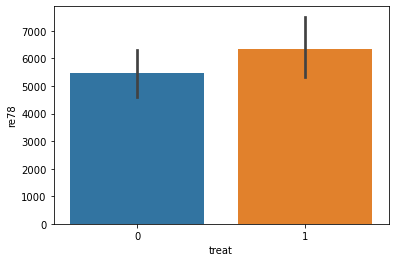

In [86]:
sns.barplot(y='re78', x='treat', data=df);

The mean `re78` is now greater in the treatment group compared to the control group (although the error bars are still significantly overlapping). 

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


We still have unbalanced race. We perform matching again by forcing both samples in a pair to have the same race:

In [95]:
# Recover the full dataset (not only matched samples)
df = raw.copy()
ctrl = df[df.treat == 0]
treat = df[df.treat == 1]

In [90]:
same_race = lambda i, j: (df.hispan[i] == df.hispan[j]) and (df.black[i] == df.black[j])

In [96]:
G = nx.Graph()

for i in ctrl.index:
    for j in treat.index:
        if same_race(i, j):
            G.add_weighted_edges_from([(i, j, similarity(df.prop[i], df.prop[j]))])
            
res = nx.max_weight_matching(G)

In [97]:
# Sanity check
len(res), ctrl.shape[0], treat.shape[0]

(116, 429, 185)

It's normal that sizes don't match, since we excluded pairs that were not of the same race. 

In [99]:
matched_samples = np.ravel(list(res))
df = df.loc[matched_samples]

We can plot again the race features to check if they are balanced:

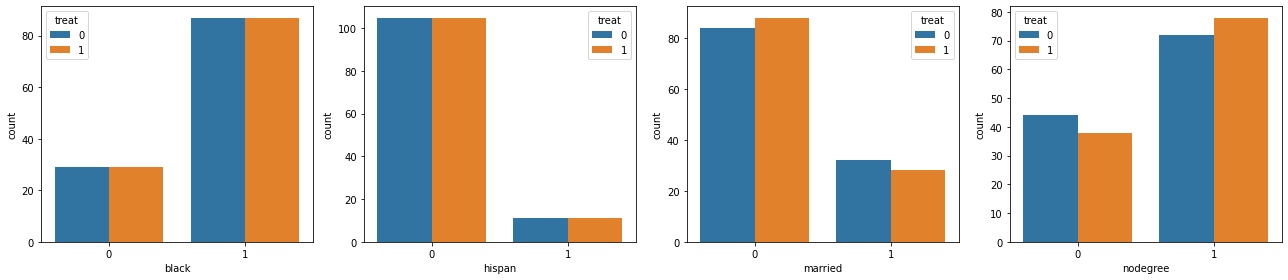

In [100]:
fig, ax = plt.subplots(1, len(cont), figsize=(18, 4))

for col, a in zip(discrete, ax):
    sns.countplot(x=col, data=df, ax=a, hue='treat')
    
plt.tight_layout()

They are pefectly balanced, as we forced this to happen. 

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [102]:
df.groupby('treat').re78.describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,116.0,5095.456025,6047.014862,0.0,0.0000,2256.4885,8942.09275,20243.38
1,116.0,6375.738003,6670.986821,0.0,758.1026,4648.7360,10160.44000,36646.95


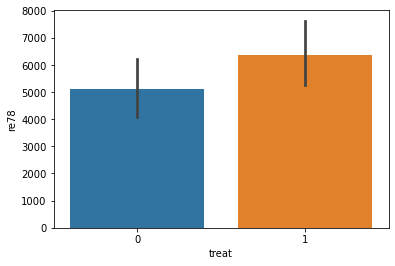

In [104]:
sns.barplot(x='treat', y='re78', data=df);